# CLIP

Посмотрим на CLIP для задачи поиска текстового описания по изображению и наоборот.

## Импорты и вспомогательные функции

In [8]:
import numpy as np
import torch
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
from pathlib import Path
from torch.nn.functional import cosine_similarity
import pandas as pd
import matplotlib.pyplot as plt

In [25]:
def preprocess_image(image_path, resize=False):
    img = Image.open(image_path).convert('RGB')
    if isinstance(resize, tuple):
        return img.resize(resize)
    return img

## Загрузим данные

In [6]:
data_dir = Path("./flickr8k") 
images_dir = data_dir / "Images"
captions_file = data_dir / "captions.txt"

In [7]:
captions_df = pd.read_csv(captions_file, names=["image", "caption"], skiprows=1)

unique_images = captions_df["image"].unique()
captions = captions_df["caption"].tolist()

In [19]:
captions_to_look = captions[:100]

In [21]:
images_to_look = unique_images[:100]

## Модель

In [5]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

model.eval()

CLIPModel(
  (text_model): CLIPTextTransformer(
    (embeddings): CLIPTextEmbeddings(
      (token_embedding): Embedding(49408, 512)
      (position_embedding): Embedding(77, 512)
    )
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0-11): 12 x CLIPEncoderLayer(
          (self_attn): CLIPSdpaAttention(
            (k_proj): Linear(in_features=512, out_features=512, bias=True)
            (v_proj): Linear(in_features=512, out_features=512, bias=True)
            (q_proj): Linear(in_features=512, out_features=512, bias=True)
            (out_proj): Linear(in_features=512, out_features=512, bias=True)
          )
          (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=512, out_features=2048, bias=True)
            (fc2): Linear(in_features=2048, out_features=512, bias=True)
          )
          (layer_norm2): LayerNorm((512,), eps=1e

In [29]:
def get_top_k_matches(query_emb, corpus_emb, corpus_items, k=5):
    similarity = cosine_similarity(query_emb, corpus_emb)
    top_k_indices = similarity.squeeze().topk(k=k, dim=-1).indices
    return [(corpus_items[i], similarity[i].item()) for i in top_k_indices]


def find_closest_sentences(image_path, all_captions, clip, k=5, device="mps"):
    image = preprocess_image(image_path)
    with torch.no_grad():
        inputs_image = processor(images=image, return_tensors="pt")
    
        inputs_image = inputs_image.to(device)
        clip = clip.to(device)

        image_features = clip.get_image_features(**inputs_image)
        inputs_text = processor(text=all_captions, return_tensors="pt", padding=True, truncation=True)
        inputs_text = inputs_text.to(device)
        text_features = clip.get_text_features(**inputs_text)
    
    plt.imshow(np.array(image))
    return get_top_k_matches(image_features.cpu(), text_features.cpu(), all_captions, k=k)


def find_closest_images(sentence, image_paths, clip, k=5, device="mps"):
    with torch.no_grad():
        inputs_text = processor(text=[sentence], return_tensors="pt", padding=True, truncation=True)

        inputs_text = inputs_text.to(device)
        clip = clip.to(device)

        text_features = clip.get_text_features(**inputs_text)
        text_features = text_features.cpu()

        clip.cpu()

    image_features_list = []
    for img_path in image_paths:
        img = preprocess_image(images_dir / img_path)
        inputs_image = processor(images=img, return_tensors="pt")
        img_features = model.get_image_features(**inputs_image)
        image_features_list.append(img_features)
    image_features = torch.cat(image_features_list)

    return get_top_k_matches(text_features, image_features, image_paths, k=k)

Closest captions to the image '1000268201_693b08cb0e.jpg':
  A little girl in a pink dress going into a wooden cabin . (score: 0.3460)
  A little girl climbing the stairs to her playhouse . (score: 0.3456)
  A little girl climbing into a wooden playhouse . (score: 0.3392)
  A child in a pink dress is climbing up a set of stairs in an entry way . (score: 0.3308)
  A girl going into a wooden building . (score: 0.2973)


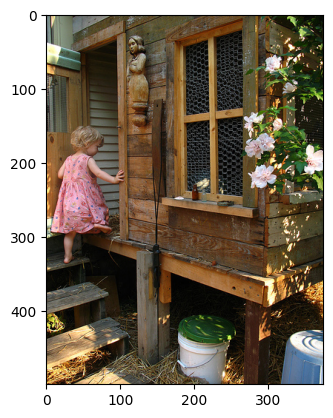

In [30]:
image_path = images_dir / unique_images[0]  
all_captions = captions_df["caption"].tolist()
closest_sentences = find_closest_sentences(
    image_path,
    captions_to_look,
    model,
    k=5
    )

print(f"Closest captions to the image '{image_path.name}':")
for sent, score in closest_sentences:
    print(f"  {sent} (score: {score:.4f})")

In [22]:
query_sentence = captions_to_look[0]
closest_images = find_closest_images(
    query_sentence,
    images_to_look,
    model,
    k=5,
    )

print(f"Closest images to the sentence '{query_sentence}':")
for img, score in closest_images:
    print(f"  {img} (score: {score:.4f})")

Closest images to the sentence 'A child in a pink dress is climbing up a set of stairs in an entry way .':
  1000268201_693b08cb0e.jpg (score: 0.3308)
  1007320043_627395c3d8.jpg (score: 0.3008)
  1105959054_9c3a738096.jpg (score: 0.2795)
  1015118661_980735411b.jpg (score: 0.2790)
  1084104085_3b06223afe.jpg (score: 0.2530)


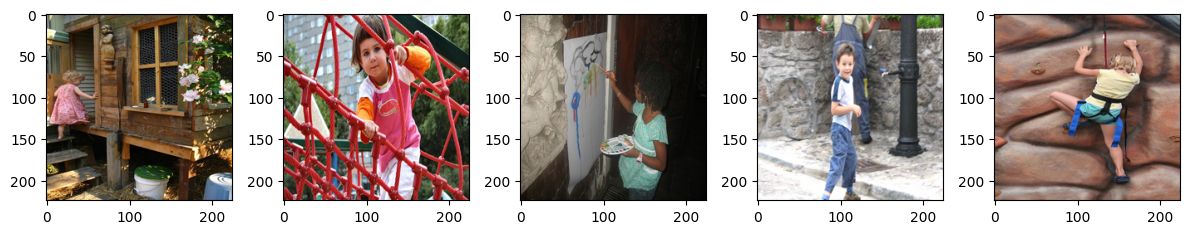

In [26]:
fig, ax = plt.subplots(1, 5, figsize=(12,10))

for i, (img, _) in enumerate(closest_images):
    img = preprocess_image(images_dir / img, resize=(224,224))
    ax[i].imshow(np.array(img))
plt.tight_layout()